# Loading in and retrieving tip/branch point objects

In [116]:
from imageio import imread, imsave
from matplotlib.pylab import plt
import numpy as np
from plantcv import plantcv as pcv

# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)

pcv.params.debug = "plot"

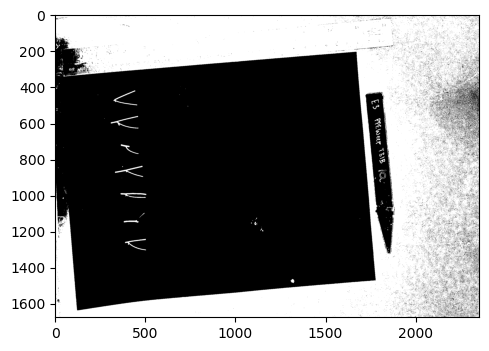

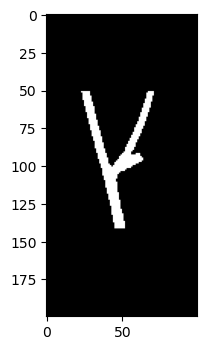

In [117]:
    ########################################
    ## Segmentation Steps Here      
    ########################################

    # We skip to reading in the previously created image mask 
    mask, path, filename = pcv.readimage("18RGBcustom_thresh_mask.png")
    #mask = pcv.rotate(mask, 90, True)

    # manually crop the mask until I figure out how to reproducible split the branches
    cropped_mask = mask[500:700, 300:400]
    cropped_mask = pcv.rotate(cropped_mask, 90, True)

    

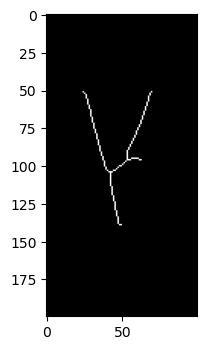

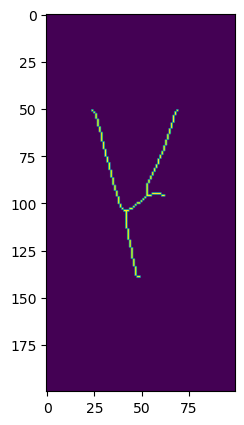

In [118]:
#skeletonize
skeleton = pcv.morphology.skeletonize(mask=cropped_mask)
fig = plt.figure(figsize=(5,5), dpi=100)
plt.imshow(skeleton)

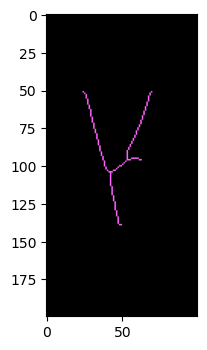

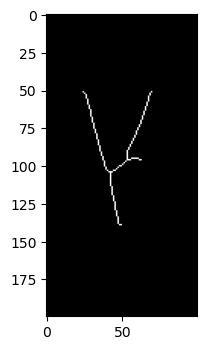

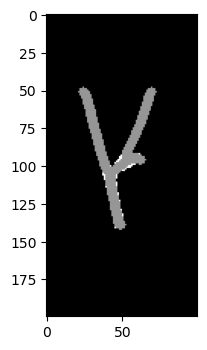

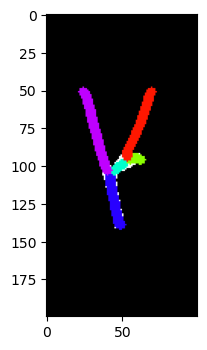

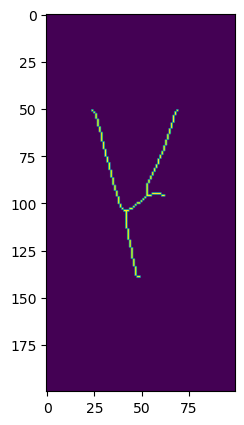

In [119]:
# Adjust line thickness with the global line thickness parameter (default = 5),
    # and provide binary mask of the plant for debugging.
pcv.params.line_thickness = 5 

# Prune the skeleton  
pruned, seg_img, edge_objects = pcv.morphology.prune(skel_img=skeleton, size=0, mask=cropped_mask)
fig = plt.figure(figsize=(5,5), dpi=100)
plt.imshow(pruned)

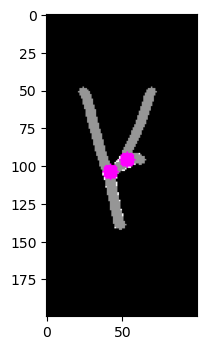

In [120]:
# Identify branch points   
branch_pts_mask = pcv.morphology.find_branch_pts(skel_img=skeleton, mask=cropped_mask, label="default")

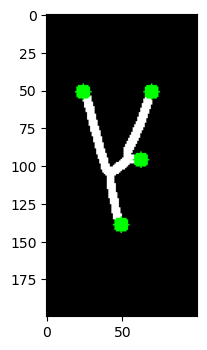

In [121]:
# Identify tip points   
tip_pts_mask = pcv.morphology.find_tips(skel_img=skeleton, mask=None, label="default")

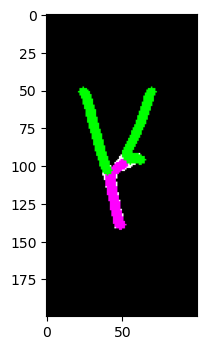

In [122]:
# Sort segments into branch objects and stem objects  
branch_obj, stem_obj = pcv.morphology.segment_sort(skel_img=skeleton, 
                                                     objects=edge_objects,
                                                     mask=cropped_mask)


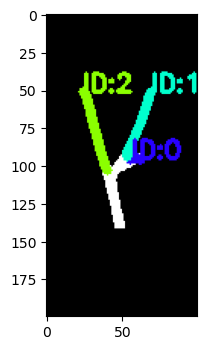

In [123]:
# Identify segments     
segmented_img, labeled_img = pcv.morphology.segment_id(skel_img=skeleton,
                                                           objects=branch_obj,
                                                           mask=cropped_mask)


#  Branch angle identifier

In [124]:
def indexer(array):
    to_process = np.where(array == 255)
    ys = to_process[0]
    xs = to_process[1]
    coords = []
    for i in range(len(xs)):
        coord = [xs[i],ys[i]]
        coords.append(coord)
    return coords

In [81]:
## find base

def find_base(tips):
    y_coordinates = []
    for i in range(len(indices)):
        y_coordinates.append(indices[i][1])
    max_index = np.argmax(y_coordinates)
    to_return = tips[max_index]
    return to_return

In [111]:
## find branchpoint with smallest euclidian distance to base
import math
def find_branch_point(array,base):
    to_process = np.where(array == 255)
    ys = to_process[0]
    xs = to_process[1]
    coords = []
    for i in range(len(xs)):
        coord = [xs[i],ys[i]]
        coords.append(coord)
    coords_to_use = []
    for i in range(len(coords)):
        if coords[i] != base:
            coords_to_use.append(coords[i])
    distances = []
    for i in range(len(coords_to_use)):
        distance = math.sqrt((coords_to_use[i][0] - base[0])**2 + (coords_to_use[i][1] - base[1])**2)
        distances.append(distance)
    branch_point_index = np.argmin(distances)
    branch_point_coord = coords_to_use[branch_point_index]        
    return branch_point_coord

In [105]:
# I've got the relevant branch point + the relevant base. Now, find the two tips farthest from the branch point. 

def find_branch_tips(array,branch_point,base):
    to_process = np.where(array == 255)
    ys = to_process[0]
    xs = to_process[1]
    coords = []
    for i in range(len(xs)):
        coord = [xs[i],ys[i]]
        coords.append(coord)
    coords_to_use = []
    for i in range(len(coords)):
        if coords[i] != base:
            coords_to_use.append(coords[i])
    
    # calculate distances of remaining tips to the branch point
    distances = []
    for i in range(len(coords_to_use)):
        distance = math.sqrt((coords_to_use[i][0] - branch_point[0])**2 + (coords_to_use[i][1] - branch_point[1])**2)
        distances.append(distance)
    original_distances = distances
    distances.sort()
    first = distances[0]
    second = distances[1]
    top_index = original_distances.index(first)
    second_index = original_distances.index(second)
    
    branch_tips = [coords_to_use[top_index],coords_to_use[second_index]]
    return branch_tips

In [108]:
# now we've got the base, our branch point, and our two things to compare against. Now
# (1) branchpoint to branch tip 1, and branchpoint to branch tip 2 vectors
# (2) Figure out the angle between them

def branch_angle(branch_tips,branch_point):
    first_branch_tip = branch_tips[0]
    second_branch_tip = branch_tips[1]
    branch_vector_one = [first_branch_tip[0] - branch_point[0],first_branch_tip[1] - branch_point[1]]
    branch_vector_two = [second_branch_tip[0] - branch_point[0],second_branch_tip[1] - branch_point[1]]
    
    unit_vector_1 = branch_vector_one / np.linalg.norm(branch_vector_one)
    unit_vector_2 = branch_vector_two / np.linalg.norm(branch_vector_two)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle_in_radians = np.arccos(dot_product)
    angle_in_degrees = np.degrees(angle_in_radians)
    
    return angle_in_degrees


In [125]:
## Put everything together into one function

def calculate_branch_angle(tip_pts_mask,branch_pts_mask):
    indices = indexer(tip_pts_mask)
    base = find_base(indices)
    branch_point = find_branch_point(branch_pts_mask,base)
    branch_tips = find_branch_tips(tip_pts_mask,branch_point,base)
    degrees = branch_angle(branch_tips,branch_point)
    return degrees

In [115]:
result = calculate_branch_angle(tip_pts_mask,branch_pts_mask)
result

45.75448874192885